In [1]:
! pip install pyro-ppl

In [2]:
import random
import string
import os
import itertools
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.utils import probs_to_logits
from utils import *

In [3]:
pcfg = {
  "name": "astronomers",
  "terminals": ["astronomers", "ears", "saw", "stars", "telescopes", "with"],
  "non_terminals": ["S", "NP", "VP", "PP", "P", "V"],
  "productions": {
    "S": [["NP", "VP"]],
    "NP": [["NP", "PP"], ["astronomers"], ["ears"], ["saw"], ["stars"], ["telescopes"]],
    "VP": [["V", "NP"], ["VP", "PP"]],
    "PP": [["P", "NP"]],
    "P": [["with"]],
    "V": [["saw"]]
  },
  "start_symbol": "S",
}
true_production_probs = {
    "S": [1.0],
    "NP": [0.4, 0.1, 0.18, 0.04, 0.18, 0.1],
    "VP": [0.7, 0.3],
    "PP": [1.0],
    "P": [1.0],
    "V": [1.0]
}
max_depth_parse_tree = 20
slient = True
terminate_symbol = "__"

In [4]:
prior_production_logits = {
    k: torch.randn((len(v),)) 
    for k, v in pcfg['productions'].items()
}
ground_truth_production_logits = {
    k: probs_to_logits(torch.tensor(true_production_probs[k]))
    for k, v in pcfg['productions'].items()
}
if not slient:
    print(prior_production_logits)
    print(ground_truth_production_logits)

In [5]:
def generate_sentences(production_logits):
    
    def sample_parse_tree(symbol = None, depth = 0, suffix = "root"):
        if symbol is None:
            symbol = pcfg['start_symbol']
        if symbol in pcfg['terminals']:
            return symbol
        elif depth > max_depth_parse_tree:
            return terminate_symbol
        else:
            if not slient:
                print("symbol=>", symbol, production_logits[symbol])
            distribution = dist.Categorical(logits=production_logits[symbol])
            production_index = distribution.sample().detach()
            production = pcfg['productions'][symbol][production_index]
            return [symbol] + \
                [sample_parse_tree(s, depth=depth + 1, suffix = f"{suffix}_d{depth}/{i}") for i, s in enumerate(production)]
    tree = sample_parse_tree()
    if not slient:
        print("tree =>", tree)
    sentence = get_leaves(tree, max_depth_parse_tree, terminate_symbol)
    # how do we state observations, levenshtein distance?
    # may also use factor on levenshtein distance between gen and obs sentences and observe with 0

    # pad and normal distribution but very low sigma
    gen_sentence = pad_sentence(sentence_to_one_hots(sentence, pcfg["terminals"]), len(sentence))
    return sentence, gen_sentence, tree
if not slient:
    print(generate_sentences(prior_production_logits))
    print(generate_sentences(ground_truth_production_logits))

In [6]:
import model as model
import guide_mean_field_v2 as guide

In [7]:
if not slient:
    model.model(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [8]:

obs_embedder_gru = nn.GRU(
    input_size=6,
    hidden_size=100,
    num_layers=1
)

def wrapped_guide(start_symbol='S', terminals=["astronomers", "ears", "saw", "stars", "telescopes", "with"], 
                  max_depth_parse_tree=20, terminate_symbol='__', observations={'obs': 0}):
    #print("print(observations['obs'].shape)", observations['obs'].shape)
    pyro.module('obs_embedder_gru', obs_embedder_gru)
    embedded_obs, _ = obs_embedder_gru(observations['obs'].unsqueeze(1))
    return guide.model(start_symbol, terminals, max_depth_parse_tree, terminate_symbol, {'obs' : embedded_obs[-1][0]})
if not slient:
    wrapped_guide(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [9]:
import tqdm
import matplotlib.pyplot as plt

In [10]:
pyro.clear_param_store()
smoke_test = False
n_steps = 10 if smoke_test else 20000
interval = 1 if smoke_test else 50
num_inference_samples = 2 if smoke_test else 10
optimiser = optim.Adam({"lr": 0.0005})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=num_inference_samples)
avg_l = 0
loss_trace = []
steps = []

In [11]:
def print_weights(name, model):
    print("@params in", name)
    for param in model.parameters():
        print(param)
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [12]:
def draw_from_model(n=1000, ground_truth=True):
    logits = production_logits if not ground_truth else ground_truth_production_logits
    sample_sentences = [generate_sentences(logits) for _ in range(n)]
    return sample_sentences
sample_sentences = draw_from_model(n=n_steps)
if not slient:
    sample_sentences[0]

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n2 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n3 = count_parameters(obs_embedder_gru) # convertion_embedding
print(n1, n2, n3, "total:", n1+n2+n3)

71073 71621 32400 total: 175094


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_mean_field_v2.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_VP_params,
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_mean_field_v2.py:149: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_NP_params,
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:30:30<00:00,  3.68it/s]


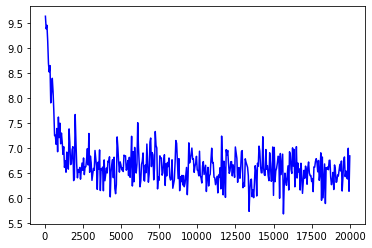

In [14]:
for step in tqdm.trange(n_steps):
    obs = sample_sentences[step]
    loss = csis.step(observations={"obs" : obs[1]})
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_trace.append(avg_l / interval)
        avg_l = 0

plt.plot(steps, loss_trace, "-b")
plt.show()

In [15]:
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [16]:
def drop_paddings(sentence_tensor):
    has_values = sentence_tensor.abs().sum(dim=-1).bool()
    return sentence_tensor[has_values]
def one_hot_sentence_to_list(sentence_tensor, terminals):
    sentence_np = sentence_tensor.cpu().detach().numpy()
    sentence_indices = np.argmax(sentence_np, axis=1)
    return [terminals[i] for i in sentence_indices]

In [17]:
def test(sentences, n=1):
    num_correct_n = 0
    num_correct_all = 0
    levenshtein_distances = {}
    for i in tqdm.trange(len(sentences)):
        obs = sentences[i]
        posterior = csis.run(observations={"obs" : obs[1]})
        marginal_ret = pyro.infer.EmpiricalMarginal(posterior)
        
        for i_sample in range(n):
            
            with torch.no_grad():
                _ret = marginal_ret()

            _ret = drop_paddings(_ret)
            num_correct_n += (torch.sum(obs[1]) == torch.sum(_ret))
            num_correct_all += torch.equal(obs[1], _ret)
            lev_dis = get_levenshtein_distance(one_hot_sentence_to_list(_ret, pcfg["terminals"]), 
                                               one_hot_sentence_to_list(obs[1], pcfg["terminals"]),
                                               pcfg["terminals"])
            if lev_dis in levenshtein_distances:
                levenshtein_distances[lev_dis] += 1
            else:
                levenshtein_distances[lev_dis] = 1
    
    avg_dis = 0  
    
    for k, v in levenshtein_distances.items():
        avg_dis += k * v

    return int(num_correct_n)  / len(sentences), int(num_correct_all) / len(sentences), levenshtein_distances, avg_dis / (len(sentences) * n)

example = ["astronomers", "saw", "stars", "with", "telescopes"]
example_sentence = sentence_to_one_hots(example, pcfg["terminals"])
print("example, n=1000", test([[None, example_sentence]], n=1000))
print("examples, 1000", test([[None, example_sentence]] * 1000))
print("train", test(sample_sentences[:1000]))
test_sentences = draw_from_model(n=1000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


example, n=1000 (0.0, 0.0, {3: 477, 2: 523}, 2.477)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.91it/s]


examples, 1000 (0.459, 0.082, {3: 157, 2: 492, 1: 266, 0: 82, 4: 3}, 1.733)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:57<00:00,  3.36it/s]


train (0.481, 0.285, {0: 285, 5: 63, 8: 35, 12: 18, 14: 19, 24: 4, 3: 83, 31: 3, 7: 40, 13: 15, 4: 63, 1: 77, 15: 11, 6: 48, 11: 13, 22: 4, 2: 100, 20: 7, 103: 1, 40: 1, 42: 2, 35: 1, 19: 5, 21: 3, 9: 28, 10: 20, 18: 9, 36: 1, 39: 1, 46: 1, 17: 7, 30: 1, 23: 3, 53: 1, 55: 1, 41: 1, 16: 4, 25: 3, 93: 1, 38: 2, 45: 1, 34: 2, 27: 4, 26: 1, 60: 2, 29: 2, 37: 1, 28: 2}, 5.691)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:45<00:00,  3.50it/s]

test (0.475, 0.311, {2: 100, 14: 17, 11: 19, 3: 83, 18: 13, 1: 61, 17: 10, 7: 28, 9: 33, 0: 311, 4: 60, 12: 26, 25: 3, 8: 27, 19: 3, 10: 22, 5: 56, 33: 1, 6: 48, 13: 22, 46: 1, 21: 3, 28: 4, 35: 1, 16: 11, 36: 3, 22: 1, 15: 8, 20: 4, 24: 3, 29: 1, 32: 1, 27: 2, 37: 2, 56: 2, 31: 1, 38: 1, 34: 1, 23: 1, 53: 1, 30: 2, 59: 1, 26: 1, 45: 1}, 5.365)


In [18]:
test_sentences = draw_from_model(n=10000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [47:58<00:00,  3.47it/s]

test (0.4675, 0.2835, {3: 813, 20: 63, 10: 241, 0: 2835, 2: 1075, 7: 407, 38: 5, 25: 38, 6: 475, 5: 542, 30: 23, 16: 102, 15: 124, 1: 712, 12: 162, 29: 15, 35: 11, 8: 298, 17: 69, 22: 54, 11: 183, 4: 682, 14: 129, 18: 78, 41: 7, 9: 289, 19: 70, 24: 36, 50: 3, 42: 3, 147: 1, 21: 54, 27: 21, 13: 151, 48: 4, 23: 41, 52: 6, 34: 10, 44: 7, 32: 10, 40: 2, 33: 14, 36: 13, 39: 5, 28: 23, 59: 2, 43: 3, 37: 6, 31: 15, 26: 21, 69: 2, 45: 6, 70: 1, 47: 6, 64: 2, 76: 2, 63: 2, 83: 1, 56: 1, 68: 3, 57: 4, 53: 4, 51: 2, 61: 2, 54: 2, 55: 2, 58: 1, 60: 1, 93: 1, 98: 1, 79: 1}, 5.5854)


In [19]:
print(loss_trace)

[9.637104629278182, 9.385585595369339, 9.45677339553833, 9.141216377615928, 8.69124255567789, 8.523401230424643, 8.652057062089444, 7.907501545846462, 8.120997325833887, 8.398270434532314, 8.136166810709984, 7.757000691965223, 7.252291554883122, 7.262647615070454, 7.080720289638266, 7.3962852433416995, 6.932107568457723, 7.624291268326342, 7.214544127807021, 7.502466713082977, 7.090924020884558, 7.304758294851053, 7.1297014747187495, 6.879975319476798, 7.032315601513256, 6.618948540752753, 6.751404409231618, 6.523481934585143, 6.923945717555471, 6.862706393945263, 6.584813967394876, 7.387758808629587, 7.117517516425578, 6.676402373010642, 6.692472784935962, 6.971210419866257, 7.032839199875598, 6.3556810436194064, 6.407761190180609, 7.675084069863661, 7.138039522251929, 6.68026114597742, 6.411492140598421, 6.575951494995097, 6.52350995533161, 6.617870779845834, 6.384474563753174, 6.565329284897598, 6.705511204378708, 6.562580586870609, 6.807580516017915, 6.474920458549823, 6.6272229402

In [20]:
print(min(loss_trace), loss_trace.index(min(loss_trace)))

5.690660878353738 312
